<a href="https://colab.research.google.com/github/KonstantinGeorgiev0/2AMM20/blob/main/jax_flax_minimal_implementation_of_nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimal Implementation of NeRF using Jax and Flax

**Authors:** [Saurav Maheshkar](https://www.kaggle.com/sauravmaheshkar) and [Soumik Rakshit](https://www.kaggle.com/soumikrakshit)

* In this notebook we aim to minimally demonstrate the task of **View Synthesis using Neural Radiance Fields**.
* The ideas used to implement the code was proposed by the paper [NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://arxiv.org/abs/2003.08934).
* We also demonstrate the useage of the frameworks [Jax](https://github.com/google/jax) and [Flax](https://github.com/google/flax) on [Google Cloud TPUs](https://cloud.google.com/tpu/).
* We use [Weights and Biases](https://wandb.ai/) for tracking the losses and metrics of our experiment in real-time.

# Table of Content

1. [**Packages 📦 and Basic Setup**](#1)

2. [**☢️ What are Neural Radiance Fields?**](#2)

3. [**🔐 Positional Encodings**](#3)

4. [**💿 The Dataset**](#4)

5. [**🎬 View Synthesis using Volume Rendering**](#5)

6. [**🧱 + 🏗 = 🏠 Training**](#6)

7. [**👀 Results**](#7)

8. [**🙏 Acknowledgments and Further Resources**](#8)

9. [**🏁 Conclusion**](#9)

<a id="1"></a>
# Packages 📦 and Basic Setup
---

## What is Jax?

<center><img src="https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png"></center>

* [**Jax**](https://github.com/google/jax) is an accelerated computation framework, that brings together **Autograd** and **XLA** for high-performance machine learning research.

* Jax provides us with a simple [**NumPy**](https://numpy.org/) and [**SciPy**](https://scipy.org/) like interface for writing our code which is then compiled by the XLA Compiler to run on CPU, GPU, and TPU.

* Jax supports the **just-in-time (JIT) compilation** of Python functions into XLA-optimized kernels using a one-function API.

* Due to its functional programming paradigm, Jax allows us to use **composable transforms** to transform a function without modifying it.

## What is Flax?

<center><img src="https://raw.githubusercontent.com/google/flax/main/images/flax_logo_250px.png"></center>

* [**Flax**](https://github.com/google/flax) is a neural network library and ecosystem for Jax designed for flexibility.

* Flax provides us with a neural network API [`flax.linen`](https://flax.readthedocs.io/en/latest/flax.linen.html) that makes it easy for us to create models in a pythonic manner.

* Flax provides us with utilities and patterns for replicated training, serialization and checkpointing, metrics, and prefetching on the device.



## Install Packages

In [ ]:
%%capture
!pip3 install -q -U jax jaxlib flax imageio-ffmpeg wandb

import os
import time
import wandb
import imageio
import requests
from typing import Any
import ipywidgets as widgets
from functools import partial
from tqdm.notebook import tqdm
from kaggle_secrets import UserSecretsClient

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

import numpy as np
import jax.numpy as jnp

from base64 import b64encode
from IPython.display import HTML
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## Setting up a [Weights & Biases](https://wandb.ai/) run

We would call [`wandb.init`](https://docs.wandb.ai/guides/track/launch) now to initialize a new job which creates a new run in Weights & Biases and launches a background process to sync data. We will sync all the configs of our experiments with the W&B run using [`wandb.config`](https://docs.wandb.ai/guides/track/config), this would make it easier for us to reproduce the results of the experiment later.

In [ ]:
os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("wandb_api_key")
wandb.init(project="nerf-jax", job_type="test")

config = wandb.config
config.near_bound = 2.
config.far_bound = 6.
config.batch_size = int(1e4)
config.num_sample_points = 256
config.epsilon = 1e10
config.positional_encoding_dims = 6
config.num_dense_layers = 8
config.dense_layer_width = 256
config.learning_rate = 5e-4
config.train_epochs = 1000
config.plot_interval = 200

wandb: Currently logged in as: sauravmaheshkar (use `wandb login --relogin` to force relogin)
2022-04-21 17:08:21.813924: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib


## Accelerator Configuration

In this notebook we'll use [Kaggle TPUs](https://www.kaggle.com/docs/tpu) to run our JAX code. In order for JAX to utilize the TPUs we need to specify it as a backend. This great code snippet by [**@odins0n**](https://www.kaggle.com/odins0n) helps us properly setup the backend.

In [ ]:
# Reference: https://www.kaggle.com/code/odins0n/jax-flax-tf-data-vision-transformers-tutorial

if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config as jax_config
    jax_config.FLAGS.jax_xla_backend = "tpu_driver"
    jax_config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print("TPU DETECTED!")
    print('Registered TPU:', jax_config.FLAGS.jax_backend_target)
elif "COLAB_TPU_ADDR" in os.environ:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
else:
    print('No TPU detected.')

DEVICE_COUNT = len(jax.local_devices())
TPU = DEVICE_COUNT==8

if TPU:
    print("8 cores of TPU ( Local devices in Jax ):")
    print('\n'.join(map(str,jax.local_devices())))

TPU DETECTED!
Registered TPU: grpc://10.0.0.2:8470
8 cores of TPU ( Local devices in Jax ):
TPU_0(host=0,(0,0,0,0))
TPU_1(host=0,(0,0,0,1))
TPU_2(host=0,(1,0,0,0))
TPU_3(host=0,(1,0,0,1))
TPU_4(host=0,(0,1,0,0))
TPU_5(host=0,(0,1,0,1))
TPU_6(host=0,(1,1,0,0))
TPU_7(host=0,(1,1,0,1))


<a id="2"></a>
# ☢️ What are Neural Radiance Fields?
---

In order to understand what exactly Neural Radiance Fields are, let us break down the phrase...

* The word **Neural** obviously means that there's a Neural Network involved,

* **Radiance** refers to the radiance of the scene that the Neural Network outputs. It is basically describing how much light is being emitted by a point in space in each direction, and

* The word **Field** means that the Neural Network models a continuous and non-discretized representation of the scene that it learns.

<div style="background-color: #90EE90 ; padding: 10px; border: 1px solid green; color: black;">
Hence, we can say that a <b>Neural Radiance Field</b> is Neural Network that models the point and a viewing direction in a 3D space to the amount of light that is being emitted by the said point in each direction in a non-discrete manner.
</div>

<figure>
  <img src="https://raw.githubusercontent.com/SauravMaheshkar/infographics/main/NeRF/NeRF%20Model.png">
  <figcaption>Figure: Overview of the Model</figcaption>
</figure>

* The Neural Network $\large F_{\theta}$ in this case is a simple **Multi-layered Perceptron** or MLP with **ReLU activation**.

* The MLP consists of 9 fully-connected layers of width 256.

* The Input to the MLP consists of 2 components:
    - $\large (x, y, z)$ which denotes the spatial position of a given point in 3D space.
    - $\large (\theta, \phi)$ denotes a given viewing direction from the point.
    - $\large (x, y, z, \theta, \phi)$ forms a single continuous 5D coordinate which is fed to the MLP.

* The output to the MLP consists of 2 components as well:
    - $\large (r, g, b)$ which denotes the view composed from the point $\large (x, y, z)$ along the direction $\large (\theta, \phi)$ in RGB colorspace.
    - $\large \sigma$ denotes the density or transparency of the point.
    - The value of $\large \sigma$ lies in the range $\large [0, \infty)$.
    - A $\large \sigma$ value of 0 means there is nothing at the point or the point is transparent and a $\large \sigma$ value of $\large \infty$ means that the point is opaque.


## Implementing the Multi-layered Perceptron Model

<div align="center">
    <img src = "https://i.imgur.com/abFIpgc.png">
</div>


The authors use a simple 9 layered MLP network with 256 channels (**no convolutions**) to map from spatial location + viewing direction to color + density. We present a simple Flax linen Module to achieve the save.

**NOTE:**

1. The use of [`@nn.compact`](https://flax.readthedocs.io/en/latest/flax.linen.html?highlight=compact#flax.linen.compact) because our various submodules definitions (Dense Layers) are co-located with their usage, thereby removing the need of a `setup` function and leading to a overall compact code.
2. The use of [`@nn.remat`](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.remat.html#flax.linen.remat) in order to recompute the model's output during a backward pass.

In [ ]:
class NeRFModel(nn.Module):
    skip_connection_index: int = 4
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = True

    @nn.remat
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        for i in range(config.num_dense_layers):
            x = nn.Dense(
                config.dense_layer_width,
                dtype=self.dtype,
                precision=self.precision
            )(x)
            x = nn.relu(x)
            # Skip connection
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
        x = nn.Dense(4, dtype=self.dtype, precision=self.precision)(x)
        return x


def initialize_model(key, input_pts_shape):
    model = NeRFModel()
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    return model, initial_params["params"]

<a id="3"></a>
# 🔐 Positional Encodings
---

Let us step down from our NeRF Model and consider a simpler problem to act as a proxy for NeRF:

> **Make a Neural Network memorize a single image.**

The model takes the input of a set of pixel coordinates $\large (x, y)$ and predicts the $\large (r, g, b)$ value of the pixel and we train this model by overfitting it on a single image with the object of memorizing that single image accurately. Note that we consider the model to be an MLP with ReLU activation function similar to our NeRFModel.

The surprising thing is that such a model containing parameters that are 8-10 times the number of pixels in the image is unable to satisfactorily memorize the image, even if trained for an extremely long time!!!

<center><img src="https://github.com/soumik12345/nerf.jax/raw/main/assets/pos_enc_1.gif"></center><br>

<div style="background-color: #90EE90 ; padding: 10px; border: 1px solid green; color: black;">
<b>NOTE:</b> The authors face the exact same problem with View Synthesis using NeRF; that a basic implementation does not work well for high frequency variations in colour and underlying geometry.
</div>

## What's The Solution?

The authors of NeRF observed that if we take the sinusoids of the input coordinates with increasing frequency and expand the feature vector out into a high-dimensional space and feed all the concatenated feature vectors into the MLP instead of the coordinates directly, the model is able to memorize the image!!!

Although the idea of Fourier Feature Mapping was presented in the original NeRF paper that we are focussing on, they didn't provide any explanation as to why it worked. The explanation was provided in a later work titled [**Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains**](https://arxiv.org/abs/2006.10739) and the explanation is there right in the title. Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).
This **Fourier Feature Mapping** or **Positional Encoding** $\large \gamma(v)$ can be represented as

$$\Large {\gamma(v) =\begin{pmatrix}
sin(v), cos(v)\\
sin(2v), cos(2v)\\
sin(4v), cos(4v)\\
...\\
sin(2^{(L-1)}v), cos(2^{(L-1)}v)\\
\end{pmatrix}}$$

<br><center><img src="https://github.com/soumik12345/nerf.jax/raw/main/assets/pos_enc_2.gif"></center><br>

Let us now implement a function that applies Positional Encoding to the inputs.

In [ ]:
def positional_encoding(inputs):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(config.positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

<div style="background-color: #90EE90 ; padding: 10px; border: 1px solid green; color: black;">
<b>NOTE:</b> The authors have noted that a basic implementation does not work well for high frequency variations in colour and underlying geometry, but mapping inputs to a higher dimensional space enables for better learning. Therefore using formula (4) as described in the paper we encode our inputs by concatenating periodic functions (sine and cosine)
</div>

<a id="4"></a>
# 💿 The Dataset
---

<!-- For this kernel, we decided to implement a much simpler version of NeRF (known as **Tiny NeRF**), which doesn't use 5 dimensional inputs and Hierarchical Sampling. We download and use the official dataset as made available [**here**](http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz). -->

Before we get into discussing View Synthesis, let's grab our dataset and take a look at it. We would be using the [**Tiny-NeRF**](http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz) dataset which is a subset of the original [**Blender dataset**](https://drive.google.com/drive/folders/128yBriW1IG_3NJ5Rp7APSTZsJqdJdfc1) that was used by the authors. The dataset basically consists of a set of images of this lego model taken from multiple poses, now the task at hand is to learn a representation of this object such that we can synthesize the view of the object from any given pose, even ones that are not present in the dataset.

We would use the first 100 images and their respective poses as training data. For validation, we use a single (image, pose) pair. The small validation subset is not going to be an issue in our case, since we essentially want our network to ***memorize*** the 3D scene given by the data on a way that enables smooth interpolation between frames.

<div style="background-color: #90EE90 ; padding: 10px; border: 1px solid green; color: black;">
<b>NOTE:</b> The Tiny-NeRF dataset doesn't use the 5 dimensional input scheme of the original Blender Dataset, but rather only the spatial positions $\large (x,y,z)$
</div>

In [ ]:
%%capture
!wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

In [ ]:
data = np.load("tiny_nerf_data.npz")
images = data["images"]
poses = data["poses"]
focal = float(data["focal"])

_, image_height, image_width, _ = images.shape

train_images, train_poses = images[:100], poses[:100]
val_image, val_pose = images[101], poses[101]

print("Train Images Shape:", train_images.shape)
print("Train Poses Shape:", train_poses.shape)
print("Validation Image Shape:", val_image.shape)
print("Validation Pose Shape:", val_pose.shape)

print(f"Images shape: {images.shape}")
print(f"Poses shape: {poses.shape}")
print(f"Focal value: {focal:.5f}")

Train Images Shape: (100, 100, 100, 3)
Train Poses Shape: (100, 4, 4)
Validation Image Shape: (100, 100, 3)
Validation Pose Shape: (4, 4)
Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal value: 138.88888


Let's have a look at some of the images from this dataset.

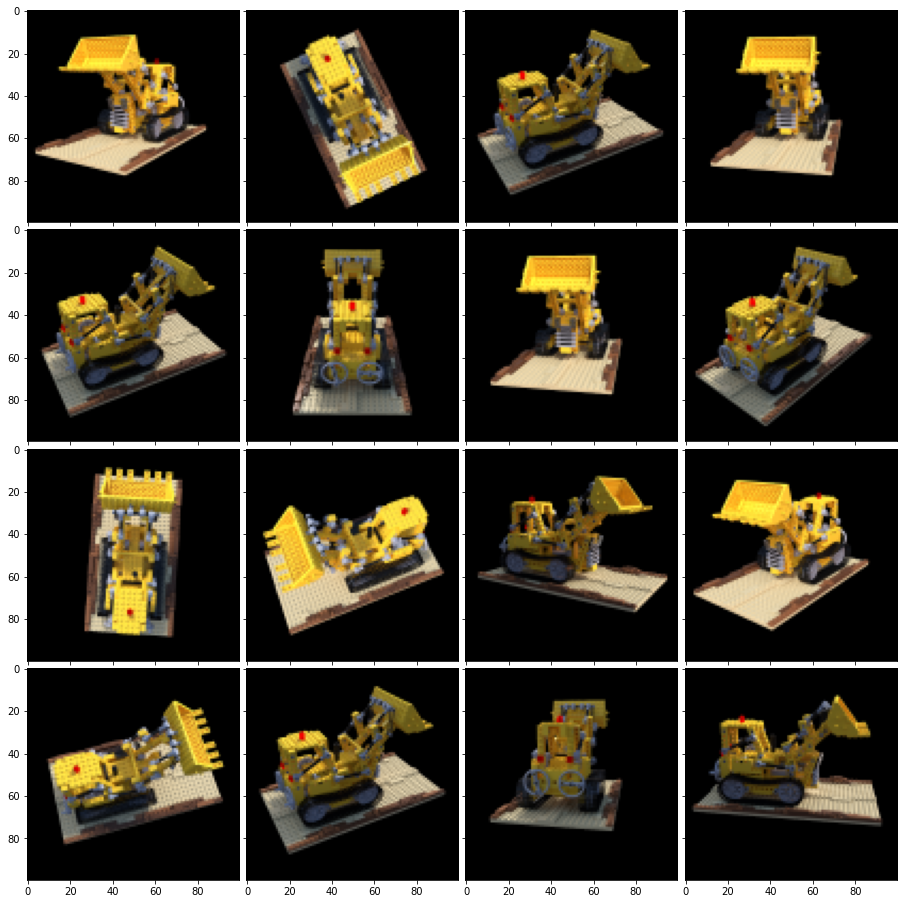

In [ ]:
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_images = images[np.random.choice(np.arange(images.shape[0]), 16)]
for ax, image in zip(grid, random_images):
    ax.imshow(image)
plt.title("Sample Images from Tiny-NeRF Data")
plt.show()

<a id="5"></a>
# 🎬 View Synthesis using Volume Rendering
---

Let's consider the task at hand here: **Novel View Synthesis** i.e. given a set of sparsely sampled images of a scene, to render an image from a given novel viewpoint. For synthesizing novel views, the authors of NeRF propose using volumetric representations to address the task of high-quality photorealistic view synthesis from a set of input RGB images. approaches are able to realistically represent complex shapes and materials, are well-suited for gradient-based optimization, and tend to produce less visually distracting artifacts than mesh-based methods.

We would be rendering the color of any ray passing through the scene using principles from **classical volume rendering**. To compute the expected color for a given ray we compute weights for each sampled point along a ray. This expected color is given a simple formula...

$$\huge
C \approx \sum_{}^{N} T_i \alpha_i c_i
$$

Now in-order to render images we follow some basic steps :-

1. March rays through the scene and generate a sampled space of 3D points (refer to the `generate_rays` and `compute_3d_points` functions respectively)

2. Use these points and their corresponding directions (2D) as input to the network to produce an output set of color + density (refer the `compute_radiance_field` function)

3. Determine the color and density of various points on the rays based on their distance (refer to the `compute_weights` and `compute_adjacent_distances` functions respectively) and then render into a 2D image.

The volume rendering pipeline is summarized by the following figure:

<center><img src="https://github.com/SauravMaheshkar/infographics/blob/main/NeRF/NeRF-Weight-Computation.png?raw=true"><center>

<div style="background-color: #90EE90 ; padding: 10px; border: 1px solid green; color: black;">
<b>NOTE:</b> for a large opacity (i.e. the object doesn't allow much light to penetrate), the value of alpha is 1 and therefore the transmittance (the ability to allow light to pass through) is almost none.
</div>

In [ ]:
def generate_rays(height, width, focal, pose):
    # Create a 2D rectangular grid for the rays corresponding to image dimensions
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing="xy")

    transformed_i = (i - width * 0.5) / focal # Normalize the x-axis coordinates
    transformed_j = -(j - height * 0.5) / focal # Normalize the y-axis coordinates
    k = -np.ones_like(i) # z-axis coordinates
    # Create the unit vectors corresponding to ray directions
    directions = np.stack([transformed_i, transformed_j, k], axis=-1)

    # Compute Origins and Directions for each ray
    camera_directions = directions[..., None, :] * pose[:3, :3]
    ray_directions = np.einsum("ijl,kl", directions, pose[:3, :3])
    ray_origins = np.broadcast_to(pose[:3, -1], ray_directions.shape)
    return np.stack([ray_origins, ray_directions])

def compute_3d_points(ray_origins, ray_directions, random_number_generator=None):
    """Compute 3d query points for volumetric rendering"""
    # Sample space to parametrically compute the ray points
    t_vals = np.linspace(config.near_bound, config.far_bound, config.num_sample_points)
    if random_number_generator is not None:
        # inject a uniform noise into the sample space to make it continuous
        t_shape = ray_origins.shape[:-1] + (config.num_sample_points,)
        noise = jax.random.uniform(
            random_number_generator, t_shape
        ) * (config.far_bound - config.near_bound) / config.num_sample_points
        t_vals = t_vals + noise

    # Compute the ray traversal points using r(t) = o + t * d
    ray_origins = ray_origins[..., None, :]
    ray_directions = ray_directions[..., None, :]
    t_vals_flat = t_vals[..., :, None]
    points = ray_origins + ray_directions * t_vals_flat
    return points, t_vals


def compute_radiance_field(model, points):
    """Compute Radiance Field"""
    # Perform forward propagation
    model_output = lax.map(model, jnp.reshape(points, [-1, config.batch_size, 3]))
    radiance_field = jnp.reshape(model_output, points.shape[:-1] + (4,))
    # Slice the model output
    opacities = nn.relu(radiance_field[..., 3])
    colors = nn.sigmoid(radiance_field[..., :3])
    return opacities, colors


def compute_adjacent_distances(t_vals, ray_directions):
    """Get distances between adjacent intervals along sample space"""
    distances = t_vals[..., 1:] - t_vals[..., :-1]
    distances = jnp.concatenate([
        distances, np.broadcast_to(
            [config.epsilon], distances[..., :1].shape
        )], axis=-1
    )
    # Multiply each distance by the norm of its corresponding direction ray
    # to convert to real world distance (accounts for non-unit directions)
    distances = distances * jnp.linalg.norm(ray_directions[..., None, :], axis=-1)
    return distances


def compute_weights(opacities, distances):
    """Compute weight for the RGB of each sample along each ray"""
    # Compute density from the opacity
    density = jnp.exp(-opacities * distances)
    alpha = 1.0 - density
    clipped_difference = jnp.clip(1.0 - alpha, 1e-10, 1.0)
    # A cumulative product is basically used to express the idea
    # of the ray not having reflected up to this sample yet
    transmittance = jnp.cumprod(
        jnp.concatenate([
            jnp.ones_like(clipped_difference[..., :1]),
            clipped_difference[..., :-1]], -1
        ), axis=-1
    )
    return alpha * transmittance

Now let's combine all of our useful functions together to enable volume rendering from the Neural Radiance Fields.

In [ ]:
def perform_volume_rendering(model, ray_origins, ray_directions, random_number_generator=None):
    # Compute 3d query points
    points, t_vals = compute_3d_points(
        ray_origins, ray_directions, random_number_generator
    )

    # Get color and opacities from the model
    opacities, colors = compute_radiance_field(model, points)

    # Get distances between adjacent intervals along sample space
    distances = compute_adjacent_distances(t_vals, ray_directions)

    # Compute weight for the RGB of each sample along each ray
    weights = compute_weights(opacities, distances)

    # Compute weighted RGB color of each sample along each ray
    rgb_map = jnp.sum(weights[..., None] * colors, axis=-2)

    # Compute the estimated depth map
    depth_map = jnp.sum(weights * t_vals, axis=-1)

    # Sum of weights along each ray; the value is in [0, 1] up to numerical error
    acc_map = jnp.sum(weights, axis=-1)

    # Disparity map is basically the inverse of depth
    disparity_map = 1. / jnp.maximum(1e-10, depth_map / jnp.sum(weights, axis=-1))


    return rgb_map, depth_map, acc_map, disparity_map, opacities

<a id="6"></a>
# 🧱 + 🏗 = 🏠 Training
---

For the Tiny NeRF implementation our loss function is simply the average square error between rendered and true colours of the various rays.

In [ ]:
def train_step(state, batch, rng):
    """Train Step"""
    inputs, targets = batch

    def loss_fn(params):
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        ray_origins, ray_directions = inputs
        rgb, *_ = perform_volume_rendering(
            model_fn, ray_origins, ray_directions, rng
        )
        return jnp.mean((rgb - targets) ** 2)

    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    gradients = lax.pmean(gradients, axis_name="batch")
    new_state = state.apply_gradients(grads=gradients)
    train_loss = jnp.mean(train_loss)
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state


@jax.jit
def validation_step(state):
    """Test Step"""
    model_fn = lambda x: state.apply_fn({"params": state.params}, x)
    ray_origins, ray_directions = val_rays
    rgb, depth, *_ = perform_volume_rendering(
        model_fn, ray_origins, ray_directions
    )
    loss = jnp.mean((rgb - val_image) ** 2)
    psnr = -10.0 * jnp.log(loss) / jnp.log(10.0)
    return rgb, depth, psnr, loss

In [ ]:
def train_and_evaluate(state, train_step_fn, validation_step_fn):
    train_loss_history, train_psnr_history = [], []
    val_loss_history, val_psnr_history = [], []

    for epoch in tqdm(range(config.train_epochs)):
        rng_index, rng_epoch = jax.random.split(jax.random.fold_in(rng, epoch))
        sharded_rngs = common_utils.shard_prng_key(rng_epoch)

        train_index = jax.random.randint(
            rng_index, (n_devices,), minval=0, maxval=len(train_rays)
        )
        train_batch = train_rays[tuple(train_index), ...], train_images[tuple(train_index), ...]
        train_loss, train_psnr, state = train_step_fn(state, train_batch, sharded_rngs)
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))
        wandb.log({"Train Loss": np.asarray(np.mean(train_loss))}, step=epoch)
        wandb.log({"Train PSNR": np.asarray(np.mean(train_loss))}, step=epoch)

        validation_state = flax.jax_utils.unreplicate(state)
        rgb, depth, val_psnr, val_loss = validation_step_fn(validation_state)
        val_loss_history.append(np.asarray(val_loss))
        val_psnr_history.append(np.asarray(val_psnr))
        wandb.log({"Validation Loss": np.asarray(val_loss)}, step=epoch)
        wandb.log({"Validation PSNR": np.asarray(val_psnr)}, step=epoch)

        if epoch % config.plot_interval == 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
            ax1.imshow(rgb)
            ax1.set_title(f"Predicted RGB at Epoch {epoch}")
            ax1.axis("off")
            ax2.imshow(depth)
            ax2.set_title(f"Predicted Depth at Epoch {epoch}")
            ax2.axis("off")
            plt.show()


    inference_state = flax.jax_utils.unreplicate(state)
    history = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
        "val_loss": val_loss_history,
        "val_psnr": val_psnr_history
    }
    return state, inference_state, history

In [ ]:
# Parallelize the train step function by applying the composable transform `jax.pmap`
parallelized_train_step = jax.pmap(train_step, axis_name="batch")

train_rays = np.stack(list(map(
    lambda x: generate_rays(image_height, image_width, focal, x), train_poses
)))
val_rays = generate_rays(image_height, image_width, focal, val_pose)

n_devices = jax.local_device_count()
key, rng = jax.random.split(jax.random.PRNGKey(0))

model, params = initialize_model(key, (image_height * image_width, 3))
optimizer = optax.adam(learning_rate=config.learning_rate)
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)
state = jax.device_put_replicated(state, jax.local_devices())

  0%|          | 0/1000 [00:00<?, ?it/s]

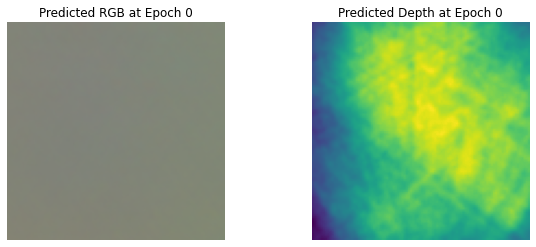

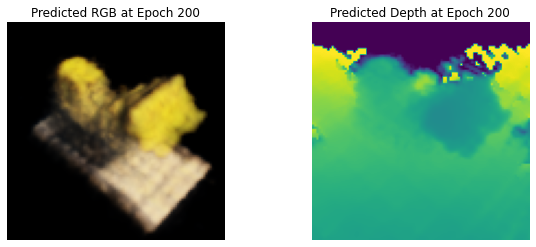

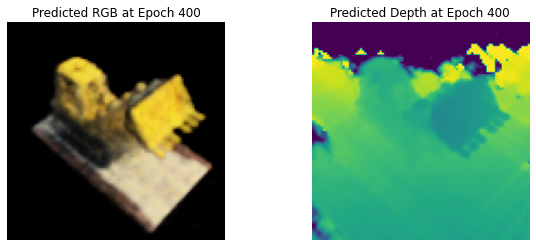

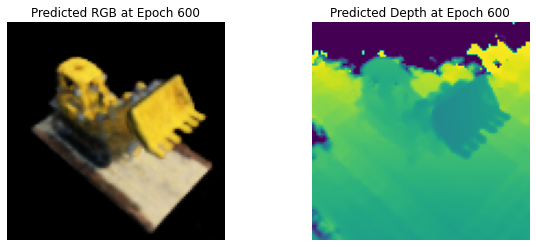

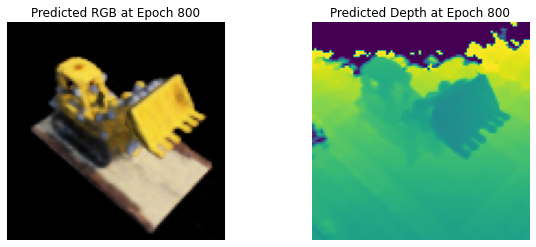

In [ ]:
state, inference_state, history = train_and_evaluate(
    state, parallelized_train_step, validation_step
)

<a id="7"></a>
# 👀 Results
---

In [ ]:
def plot_result(history, item):
    train_item = "train_" + item
    val_item = "val_" + item
    plt.plot(history[train_item], label=train_item)
    plt.plot(history[val_item], label=val_item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

Let's see how our model performed by looking at the Loss and PSNR value over epochs.

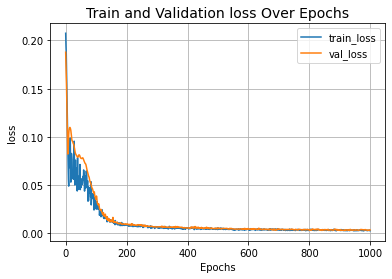

In [ ]:
plot_result(history, "loss")

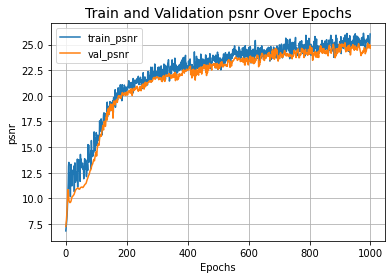

In [ ]:
plot_result(history, "psnr")

These code cells contain basic matrices to perform camera projection to render images.

In [ ]:
def get_translation_matrix(t):
    return np.asarray(
        [
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, t],
            [0, 0, 0, 1],
        ]
    )

def get_rotation_matrix_phi(phi):
    return np.asarray(
        [
            [1, 0, 0, 0],
            [0, np.cos(phi), -np.sin(phi), 0],
            [0, np.sin(phi), np.cos(phi), 0],
            [0, 0, 0, 1],
        ]
    )

def get_rotation_matrix_theta(theta):
    return np.asarray(
        [
            [np.cos(theta), 0, -np.sin(theta), 0],
            [0, 1, 0, 0],
            [np.sin(theta), 0, np.cos(theta), 0],
            [0, 0, 0, 1],
        ]
    )


def pose_spherical(theta, phi, radius):
    camera_to_world_transform = get_translation_matrix(radius)
    camera_to_world_transform = get_rotation_matrix_phi(phi / 180.0 * np.pi) @ camera_to_world_transform
    camera_to_world_transform = get_rotation_matrix_theta(theta / 180.0 * np.pi) @ camera_to_world_transform
    camera_to_world_transform = np.array([
        [-1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]
    ]) @ camera_to_world_transform
    return camera_to_world_transform


@jax.jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn(
        {"params": inference_state.params}, x
    )
    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(
        model_fn, ray_origins, ray_directions
    )
    img = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return img, depth, acc, disparity, opacities


def get_frames():
    video_angle = jnp.linspace(0.0, 360.0, 120, endpoint=False)
    camera_to_world_transform = map(lambda th: pose_spherical(th, -30.0, 4.0), video_angle)
    rays = np.stack(list(map(
        lambda x: generate_rays(
            image_height, image_width, focal, x[:3, :4]
        ), camera_to_world_transform
    )))
    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)
    rgb_frames = np.asarray(rgb_frames)
    depth_frames = np.asarray(depth_frames)
    acc_maps = np.asarray(acc_maps * 255.)
    disparity_maps = np.asarray(disparity_maps * 255.)
    return rgb_frames, depth_frames, acc_maps, disparity_maps

In [ ]:
%%capture

rgb_frames, depth_frames, acc_maps, disparity_maps = get_frames()

imageio.mimwrite("rgb_video.mp4", tuple(rgb_frames), fps=30, quality=7)
imageio.mimwrite("depth_video.mp4", tuple(depth_frames), fps=30, quality=7)
imageio.mimwrite("acc_video.mp4", tuple(acc_maps), fps=30, quality=7)
imageio.mimwrite("disparity_video.mp4", tuple(disparity_maps), fps=30, quality=7)

wandb.log({"RGB Rendering": wandb.Video("rgb_video.mp4", fps=30, format="gif")})
wandb.log({"Depth Rendering": wandb.Video("depth_video.mp4", fps=30, format="gif")})
wandb.log({"Accuracy Rendering": wandb.Video("acc_video.mp4", fps=30, format="gif")})
wandb.log({"Disparity Map Rendering": wandb.Video("disparity_video.mp4", fps=30, format="gif")})

2022-04-21 17:22:33.286124: W external/org_tensorflow/tensorflow/compiler/xla/python/tpu_driver/client/tpu_client.cc:618] TPU Execute is taking a long time. This might be due to a deadlock between multiple TPU cores or a very slow program.
[swscaler @ 0x5e55fc0] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x738c800] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x63c2800] Warning: data is not aligned! This can lead to a speed loss
[swscaler @ 0x5a2f800] Warning: data is not aligned! This can lead to a speed loss


Let's see some of the outputs from our trained model.

## Interactive RGB Reconstructed View


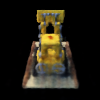
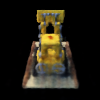
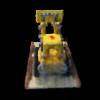
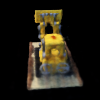
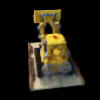
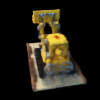
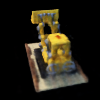
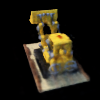
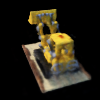
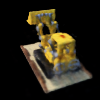
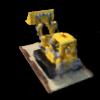
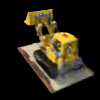
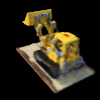
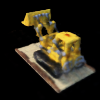
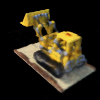
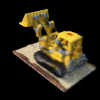
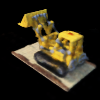
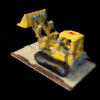
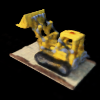
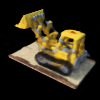
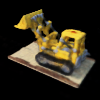
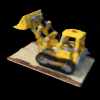
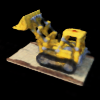
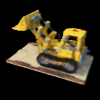
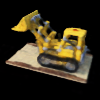
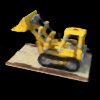
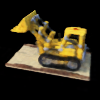
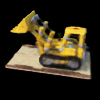
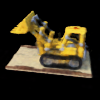
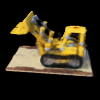
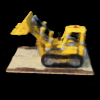
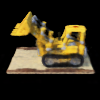
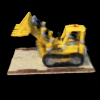
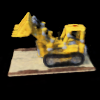
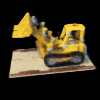
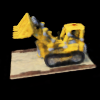
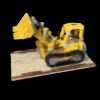
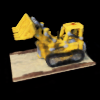
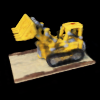
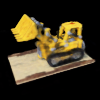
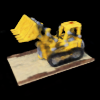
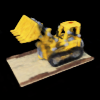
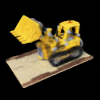
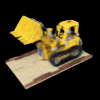
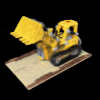
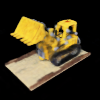
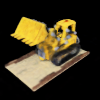
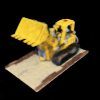
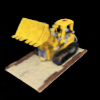
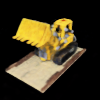
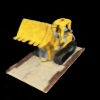
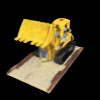
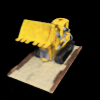
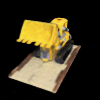
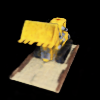
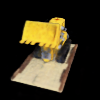
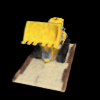
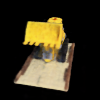
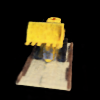
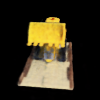
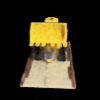
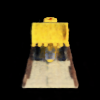
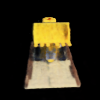
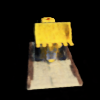
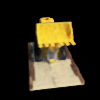
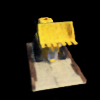
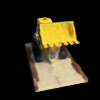
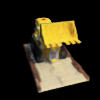
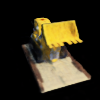
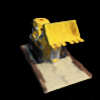
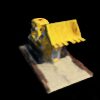
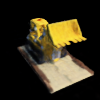
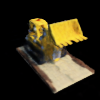
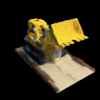
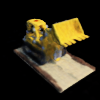
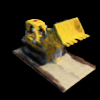
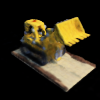
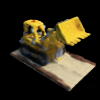
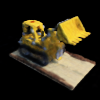
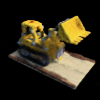
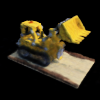
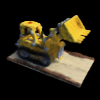
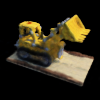
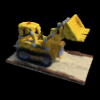
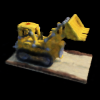
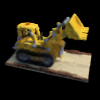
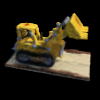
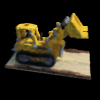
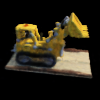
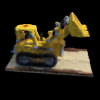
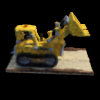
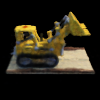
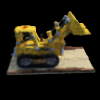
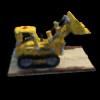
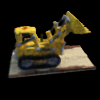
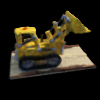
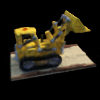
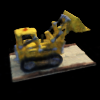
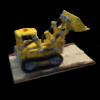
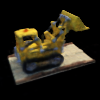
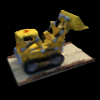
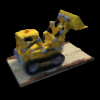
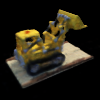
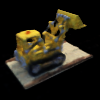
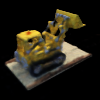
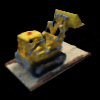
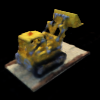
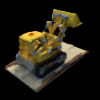
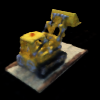
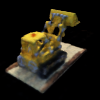
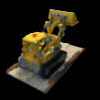
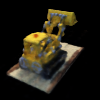
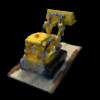
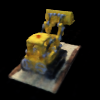
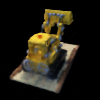
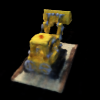
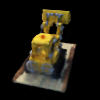
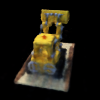
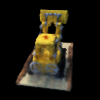
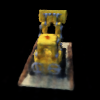
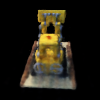

In [ ]:
fig = px.imshow(
    rgb_frames,
    animation_frame=0,
    binary_string=True,
    labels=dict(animation_frame="slice")
)
fig.update_layout(title="RGB Reconstruction")
wandb.log({"RGB Reconstruction": fig})
fig.show()

## RGB Video

In [ ]:
mp4_file = open("rgb_video.mp4", "rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4_file).decode()}"
HTML(
    """
<video width=500 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)

## Reconstructed DepthMap View


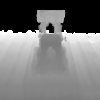
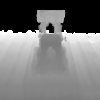
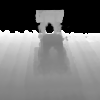
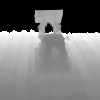
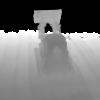
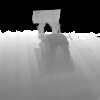
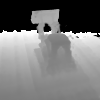
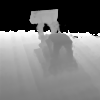
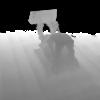
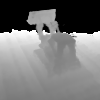
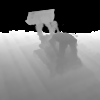
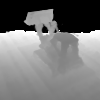
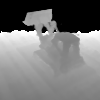
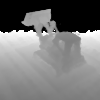
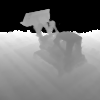
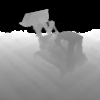
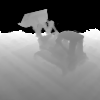
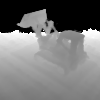
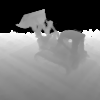
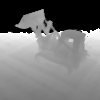
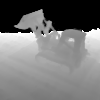
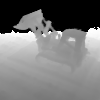
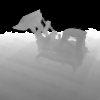
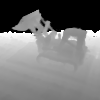
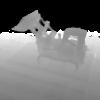
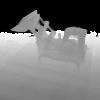
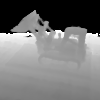
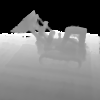
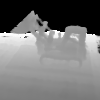
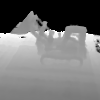
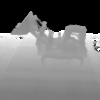
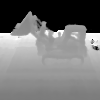
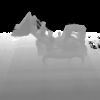
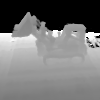
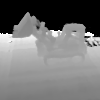
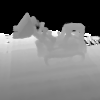
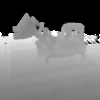
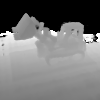
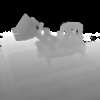
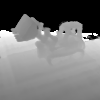
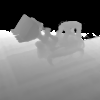
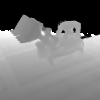
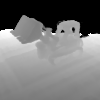
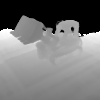
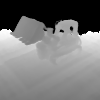
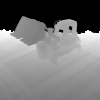
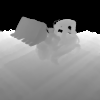
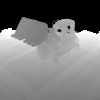
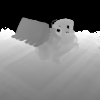
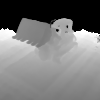
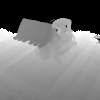
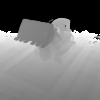
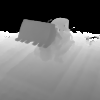
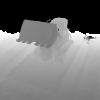
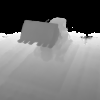
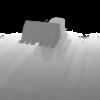
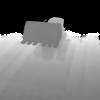
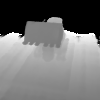
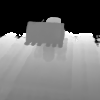
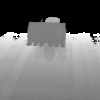
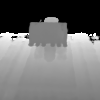
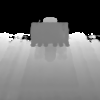
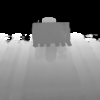
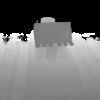
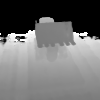
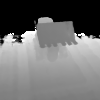
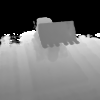
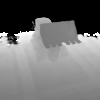
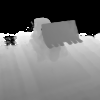
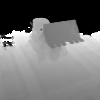
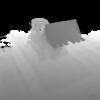
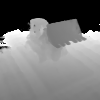
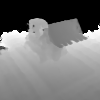
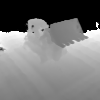
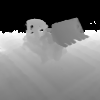
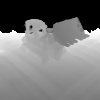
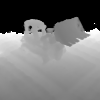
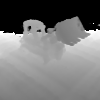
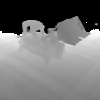
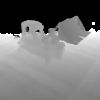
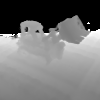
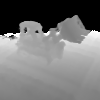
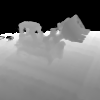
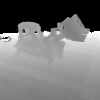
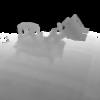
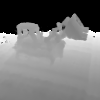
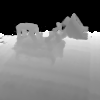
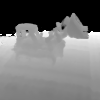
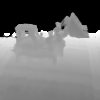
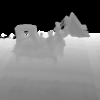
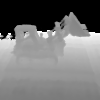
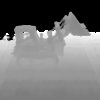
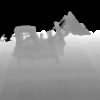
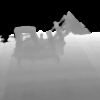
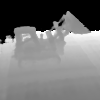
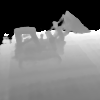
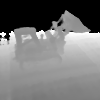
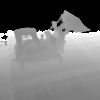
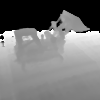
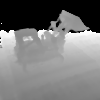
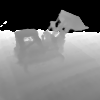
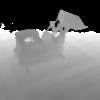
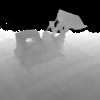
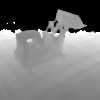
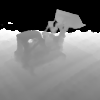
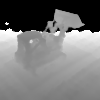
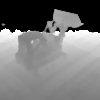
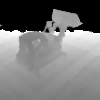
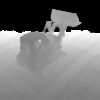
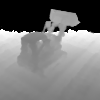
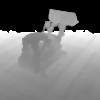
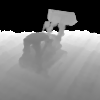
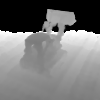
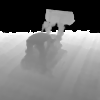
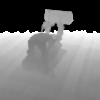
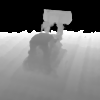
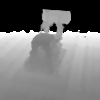
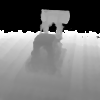
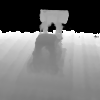
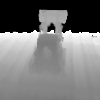
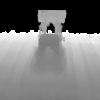

In [ ]:
fig = px.imshow(
    depth_frames,
    animation_frame=0,
    binary_string=True,
    labels=dict(animation_frame="slice")
)
fig.update_layout(title="Depthmap Reconstruction")
wandb.log({"Depthmap Reconstruction": fig})
fig.show()

## DepthMap Video

In [ ]:
mp4_file = open("depth_video.mp4", "rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4_file).decode()}"
HTML(
    """
<video width=500 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)

In [ ]:
wandb.finish()

Train Loss,█▆▅▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train PSNR,█▆▅▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,██▇▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation PSNR,▁▁▁▂▃▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇███████
Train Loss,0.0026
Train PSNR,0.0026
Validation Loss,0.00344
Validation PSNR,24.63321


<a id="8"></a>
# 🙏 Acknowledgments and Further Reading
---

* The ideas used in this report are based primarily on the papers [**NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis**](https://arxiv.org/abs/2003.08934) and [**Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains**](https://arxiv.org/abs/2006.10739).

* This work is primarily based on [*tiny_nerf.ipynb*](https://github.com/bmild/nerf/blob/master/tiny_nerf.ipynb) that was used by the authors to demonstrate the concept of NeRF on the Tiny-NeRF dataset.

* Our work also draws inspiration from [**3D volumetric rendering with NeRF**](https://keras.io/examples/vision/nerf/) on the [Keras Docs](https://keras.io/) by [Aritra Roy Gosthipaty](https://twitter.com/arig23498) and [Ritwik Raha](https://twitter.com/ritwik_raha).

* We also referred to the official Jax implementation of NeRF [google-research/jaxnerf](https://github.com/google-research/google-research/tree/master/jaxnerf) and the unofficial implementation by [myagues/flax_nerf](https://github.com/myagues/flax_nerf).

* Several theoretical explanations used in this notebook were derived [Jon Barron's talk at MIT on NeRF](https://www.youtube.com/watch?v=HfJpQCBTqZs&t=1434s).

* Several of the figures used in this notebook were inspired by the figures from the respective papers and [the official project page of NeRF](https://www.matthewtancik.com/nerf).

* The snippets for Positional Encoding were derived from the [NeurIPS 2020 Spotlight video](https://www.youtube.com/watch?v=nVA6K6Sn2S4) for the paper.

* [**Ray Tracing in One Weekend Book Series**](https://raytracing.github.io/) by [Peter Shirley](https://github.com/petershirley) provided us with an excellent primer on Ray Tracing.

* We also wrote a detailed account on our implementation as a [**Weights & Biases Report**](https://wandb.ai/wandb/nerf-jax/reports/Implementing-NeRF-in-Jax--VmlldzoxODA2NDk2) where we take a look at multiple experiments with different hyperparameters and compare the results without and with positional encodings.

<a id="9"></a>
# 🏁 Conclusion
---

In this report, we covered the following topics:

* A basic overview of programming with [Jax](https://jax.readthedocs.io/en/latest/index.html) and [Flax](https://flax.readthedocs.io/en/latest/) for [Google Cloud TPUs](https://www.kaggle.com/docs/tpu).

* Using [Neural Radiance Fields](https://www.matthewtancik.com/nerf) for representing 3D scenes as a function of mapping spatial locations and viewing directions to the radiance of the point.

* Using [Fourier Features](https://bmild.github.io/fourfeat/index.html) obtained from the data to let Neural Networks better learn the intrinsic representations.

* Synthesizing 3D views from a pre-trained Neural Radiance Field using Ray Tracing and Volume Rendering.

* Using [Weights & Biases](https://wandb.ai/) to track our experiments, compare results, ensure reproducibility, and track utilization of the TPU during our experiment.